In [1]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [2]:
import numpy as np
import pandas as pd
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [3]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func

In [4]:
# create engine to hawaii.sqlite
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [5]:
# reflect an existing database into a new model
Base = automap_base()
# reflect the tables
Base.prepare(autoload_with=engine)

In [6]:
# View all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [7]:
# Save references to each table
Measurement = Base.classes.measurement
Station = Base.classes.station

In [8]:
 # Use the session to query Demographics table and display the first 5 locations
#for row in session.query(Demographics, Demographics.location).limit(5).all():
    #print(row)

In [9]:
# Create our session (link) from Python to the DB
session = Session(engine)

# Exploratory Precipitation Analysis

In [10]:
from sqlalchemy import inspect
inspector = inspect(engine)
columns = inspector.get_columns('measurement')
for c in columns:
    print(c['name'], c["type"])

id INTEGER
station TEXT
date TEXT
prcp FLOAT
tobs FLOAT


In [11]:
# Find the most recent date in the data set.
recent = session.query(Measurement.date).order_by(Measurement.date.desc()).first()
recent

('2017-08-23',)

In [12]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results. 
# Starting from the most recent data point in the database. 

# Calculate the date one year from the last date in data set.
#https://www.interviewqs.com/ddi-code-snippets/substring-python
query_date = dt.date(int((recent[0][:4])), int((recent[0][6:7])), int((recent[0][-2:]))) - pd.DateOffset(months=12)
qd = query_date.strftime("%Y-%m-%d")
qd

'2016-08-23'

In [13]:
# Perform a query to retrieve the data and precipitation scores

precipitation = session.query(Measurement.date, Measurement.prcp).\
                filter(Measurement.date >= qd).all()

In [14]:
# Save the query results as a Pandas DataFrame. Explicitly set the column names
# Sort the dataframe by date

df = pd.DataFrame(precipitation, columns=['date', 'prcp'])
df = df.rename(columns = {'date':'Date', 'prcp':'precipitation'})
df = df.dropna()
df =df.sort_values(by='Date')
df

,Date,precipitation
0,2016-08-23,0.00
1192,2016-08-23,0.02
704,2016-08-23,0.05
1881,2016-08-23,0.70
361,2016-08-23,0.15
...,...,...
2228,2017-08-22,0.50
360,2017-08-23,0.00
1528,2017-08-23,0.08
1008,2017-08-23,0.00


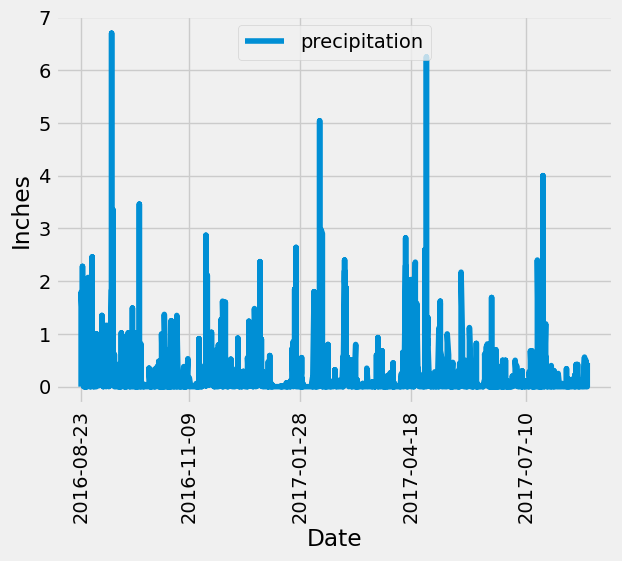

In [15]:
# Use Pandas Plotting with Matplotlib to plot the data

precip_line = plt.plot(df['Date'], df['precipitation'], label='precipitation')
plt.xlabel("Date")
plt.ylabel("Inches")
plt.xticks(['2016-08-23','2016-11-09','2017-01-28','2017-04-18','2017-07-10'])
plt.legend(loc='upper center')
plt.xticks(rotation=90)
plt.show()

In [16]:
# Use Pandas to calculate the summary statistics for the precipitation data
df.describe()

,precipitation
count,2021.000000
mean,0.177279
std,0.461190
min,0.000000
25%,0.000000
50%,0.020000
75%,0.130000
max,6.700000


# Exploratory Station Analysis

In [17]:
inspector = inspect(engine)
columns = inspector.get_columns('station')
for c in columns:
    print(c['name'], c["type"])

id INTEGER
station TEXT
name TEXT
latitude FLOAT
longitude FLOAT
elevation FLOAT


In [18]:
# Design a query to calculate the total number of stations in the dataset
session.query(Station.name).count()

9

In [19]:
# Design a query to find the most active stations (i.e. which stations have the most rows?)
# List the stations and their counts in descending order.

from sqlalchemy import desc
sel = [Measurement.station,
      func.count(Measurement.station)]

active = session.query(*sel).\
    group_by(Measurement.station).\
    order_by(desc(func.count(Measurement.station))).all()
active

[('USC00519281', 2772),
 ('USC00519397', 2724),
 ('USC00513117', 2709),
 ('USC00519523', 2669),
 ('USC00516128', 2612),
 ('USC00514830', 2202),
 ('USC00511918', 1979),
 ('USC00517948', 1372),
 ('USC00518838', 511)]

In [20]:
# Using the most active station id from the previous query, calculate the lowest, highest, and average temperature.
sel2 = [func.min(Measurement.tobs),
       func.max(Measurement.tobs),
       func.avg(Measurement.tobs)]

most_active = session.query(*sel2).\
    filter((Measurement.station) == active[0][0]).\
    group_by(Measurement.station).all()

most_active   

[(54.0, 85.0, 71.66378066378067)]

In [21]:
qd

'2016-08-23'

In [22]:
# Using the most active station id
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram

sel3 = [Measurement.tobs]

histogram = session.query(*sel3).\
    filter((Measurement.date) >= qd).\
    filter((Measurement.station) == active[0][0]).all()

hist_list = []

for h in histogram:
    hist_list.append(h[0])

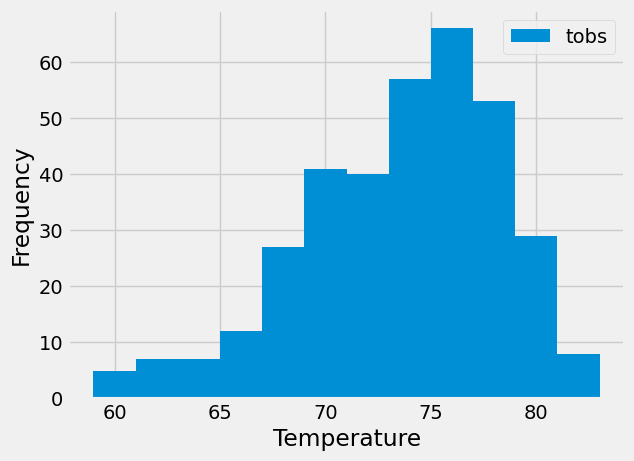

In [23]:
plt.hist(hist_list, bins=12, label="tobs")
plt.xlabel('Temperature')
plt.ylabel('Frequency')
plt.legend()
plt.show()

# Close Session

In [24]:
# Close Session
session.close()